# Homework week01

In [1]:
# ! pip install -q numpyro arviz causalgraphicalmodels daft

import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optimpi
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

/Users/Huayi1/Desktop/DSprojects/stat_rethinking_2022/numpyro_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Qn1: 4 water, 11 land

In [2]:
water = 4; land = 11
Npoints = 1000

# define grid
p_grid = jnp.linspace(start=0, stop=1, num=Npoints)

# define prior
prior = jnp.repeat(1, Npoints)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=water+land, probs=p_grid).log_prob(water))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

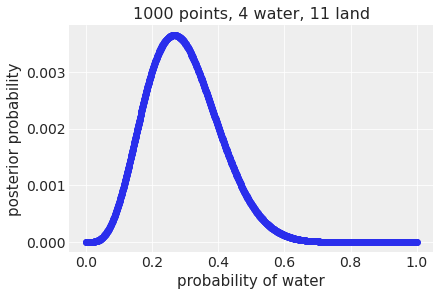

In [3]:
plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f"{Npoints} points, {water} water, {land} land")
plt.show()

## Qn2: 4 water 2 land, prior = 0 when p < 0.5, otherwise constant 

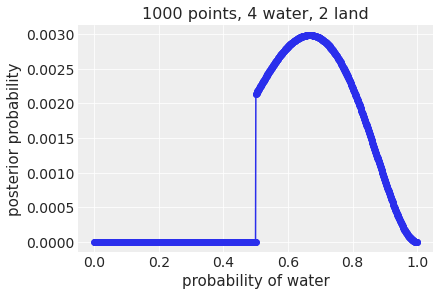

In [4]:
water = 4; land = 2
Npoints = 1000

# define grid
p_grid = jnp.linspace(start=0, stop=1, num=Npoints)

# define prior
prior = jnp.repeat(1, Npoints)
prior = prior.at[p_grid < 0.5].set(0)

# compute likelihood at each value in grid
likelihood = jnp.exp(dist.Binomial(total_count=water+land, probs=p_grid).log_prob(water))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / jnp.sum(unstd_posterior)

plt.plot(p_grid, posterior, "-o")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f"{Npoints} points, {water} water, {land} land")
plt.show()

## Qn3: Compute 89% percentile and HPDI intervals for posterior in Qn2. Which is wider? Why? If you had only the information in the interval, what might you misunderstand about the shape of the posterior distribution

In [5]:
key = random.PRNGKey(41)
samples = random.choice(key, a = p_grid, shape = (1000,1), p = posterior)

In [6]:
percentile_interval = [jnp.percentile(samples,100-89),jnp.percentile(samples,89)]
percentile_interval

[DeviceArray(0.5515515, dtype=float32), DeviceArray(0.84795797, dtype=float32)]

In [7]:
def hpd(trace, mass_frac) :
    """
    Returns highest probability density region given by
    a set of samples.

    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
        
    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD
    """
    # Get sorted list
    d = jnp.sort(jnp.copy(trace),axis=0)

    # Number of total samples taken
    n = len(trace)
    
    # Get number of samples that should be included in HPD
    n_samples = jnp.floor(mass_frac * n).astype(int)
    
    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]
    
    # Pick out minimal interval
    min_int = jnp.argmin(int_width)
    
    # Return interval
    return jnp.array([d[min_int], d[min_int+n_samples]])

In [8]:
hpd(samples, 0.89)

DeviceArray([[0.5015015],
             [0.8488488]], dtype=float32)

In [9]:
numpyro.diagnostics.hpdi(samples, 0.89)

array([[0.5015015],
       [0.8488488]], dtype=float32)